#### Importiamo le librerie necessarie. Useremo ResNet50.

In [2]:
from tensorflow import keras
import numpy as np
import tarfile
from time import time
from tensorflow.keras.applications import resnet50, vgg19, mobilenet_v2, xception, resnet
import matplotlib.pyplot as plt
import pandas as pd
import datetime, os
import pathlib
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import inception_v3
from IPython import display
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the TensorBoard notebook extension
%load_ext tensorboard

## Creiamo train e test set

## Prima configurazione

In [5]:
train_dir = "data_mel/train" 
val_dir = "data_mel/val"
test_dir = "data_mel/test"

In [6]:
species = np.array(tf.io.gfile.listdir(str(train_dir)))
species = species[species != 'README.md']
n_classes= len(species)
print('Species:', species)

Species: ['Alces_alces' 'Bos_taurus' 'Cervus_elaphus' 'Equus_caballus'
 'Lutra_lutra' 'Ovis' 'Pan' 'Panthera_leo' 'Procyon' 'Vulpes']


In [8]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= resnet.preprocess_input)
                                                                #shear_range=0.2,
                                                                #zoom_range=0.2,
                                                                #horizontal_flip=True,
                                                                #rotation_range=20,
                                                                #width_shift_range=0.2,
                                                                #height_shift_range=0.2,
                                                                #brightness_range=[0.5, 1.5])


train_generator = train_processing.flow_from_directory(directory = train_dir,
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1234)

Found 916 images belonging to 10 classes.


#### Ora andiamo a definire il test generator, in cui non applicheremo alcun tipo di data agumentation ovviamente, in quanto i dati di test devono essere utilizzati come sono.

In [9]:
val_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

val_generator = val_processing.flow_from_directory(
        directory=val_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 119 images belonging to 10 classes.


In [51]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

test_generator = test_processing.flow_from_directory(
        directory=test_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=False
)

Found 148 images belonging to 10 classes.


In [52]:
dict_classes = {}
for class_el in os.listdir(train_dir):
    dict_classes[class_el] = len(os.listdir(f"{train_dir}/{class_el}"))

dict_classes

{'Alces_alces': 70,
 'Bos_taurus': 215,
 'Cervus_elaphus': 105,
 'Equus_caballus': 80,
 'Lutra_lutra': 120,
 'Ovis': 70,
 'Pan': 66,
 'Panthera_leo': 70,
 'Procyon': 44,
 'Vulpes': 76}

In [53]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = 916

weight_for_0 = (1 / 70)*(total)/10.0 
weight_for_1 = (1 / 215)*(total)/10.0
weight_for_2 = (1 / 105)*(total)/10.0 
weight_for_3 = (1 / 80)*(total)/10.0
weight_for_4 = (1 / 120)*(total)/10.0 
weight_for_5 = (1 / 70)*(total)/10.0
weight_for_6 = (1 / 66)*(total)/10.0 
weight_for_7 = (1 / 70)*(total)/10.0
weight_for_8 = (1 / 44)*(total)/10.0 
weight_for_9 = (1 / 76)*(total)/10.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5, 6: weight_for_6, 7: weight_for_7, 8: weight_for_8, 9: weight_for_9}

#### Importiamo il modello con i pesi adatti (imagenet), e settiamo i layer iniziali come non allenabili

In [54]:
base_net = resnet.ResNet50(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3), pooling="avg")

In [55]:
for layer in base_net.layers:
    layer.trainable = False

In [56]:
base_net.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Ora aggiungiamo due fully connected layers e poi creiamo un nuovo modello "net", dato dalla combinazione dei due 

In [177]:
# Output of the base_net model
x = base_net.output
x = keras.layers.Dropout(0.5)(x)
x= keras.layers.ReLU()(x)
x = keras.layers.BatchNormalization()(x)
x=keras.layers.Dense(50, activation='relu')(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)

# final fully-connected layer + SoftMax 
pred = keras.layers.Dense(n_classes, activation='softmax')(x)

In [178]:
model1 = keras.Model(inputs=base_net.input, outputs=pred)

In [180]:
model=model1

#### Compiliamo il modello usando come loss la categorical crossentropy, come optimizer RMSprop e come metrica l'accuracy

In [182]:
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(lr=0.001),
            metrics=['accuracy'])

#### Ora fittiamo il modello con 10 epoche e visualizziamo i risultati in termini di accuracy e loss su train e test set

In [183]:
cp_callback = keras.callbacks.ModelCheckpoint(filepath="monodim_weights",
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor="val_accuracy",
                                                 verbose=1)

from tensorflow.keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    if epoch > 7:
        lr = 0.0005
    if epoch > 12:
        lr = 0.00005
    return lr

In [184]:
history1 = model.fit(train_generator,
          epochs=30,
          validation_data=val_generator,
          callbacks=[cp_callback, LearningRateScheduler(lr_scheduler, verbose=1)], class_weight=class_weight)

Epoch 1/30

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
29/29 [==============================] - 11s 236ms/step - loss: 2.4738 - accuracy: 0.2186 - val_loss: 1.7410 - val_accuracy: 0.3866

Epoch 00001: val_accuracy improved from -inf to 0.38655, saving model to monodim_weights
Epoch 2/30

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
29/29 [==============================] - 5s 186ms/step - loss: 1.1513 - accuracy: 0.5872 - val_loss: 1.5114 - val_accuracy: 0.4706

Epoch 00002: val_accuracy improved from 0.38655 to 0.47059, saving model to monodim_weights
Epoch 3/30

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
29/29 [==============================] - 6s 191ms/step - loss: 0.9177 - accuracy: 0.7021 - val_loss: 1.3165 - val_accuracy: 0.5714

Epoch 00003: val_accuracy improved from 0.47059 to 0.57143, saving model to monodim_weights
Epoch 4/30

Epoch 00004: LearningRateSched

In [185]:
# Confusion matrix
def c_matrix(y_val, y_pred, classes):
    cm = confusion_matrix(y_val, y_pred)
    fig, ax= plt.subplots(figsize = (8,6))
    sns.heatmap(cm, annot=True, annot_kws={"size": 10},
               linewidths=.2, fmt="d", cmap="PuBu")
    plt.xlabel("True Class", size = 12, horizontalalignment="right")
    plt.ylabel("Predicted Class", size = 12)
    ax.set_yticklabels(classes, rotation = 45, fontdict= {'fontsize': 10})
    ax.set_xticklabels(classes, rotation = 30, fontdict= {'fontsize': 10})
    plt.title("Confusion matrix", size = 20)
    plt.show()


Y_pred = model.predict_generator(test_generator, 148 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
species = ["Alces_alces", "Bos_taurus", "Cervus_elaphus", "Equus_caballus",
           "Lutra_lutra", "Ovis", "Pan", "Panthera_leo", "Procyon", "Vulpes"]
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=species))

Classification Report
                precision    recall  f1-score   support

   Alces_alces       0.83      0.42      0.56        12
    Bos_taurus       0.83      0.88      0.85        33
Cervus_elaphus       0.61      0.69      0.65        16
Equus_caballus       0.67      0.57      0.62        14
   Lutra_lutra       0.94      0.94      0.94        16
          Ovis       0.65      0.92      0.76        12
           Pan       0.92      1.00      0.96        11
  Panthera_leo       0.73      0.92      0.81        12
       Procyon       0.86      0.75      0.80         8
        Vulpes       1.00      0.71      0.83        14

      accuracy                           0.79       148
     macro avg       0.80      0.78      0.78       148
  weighted avg       0.80      0.79      0.79       148



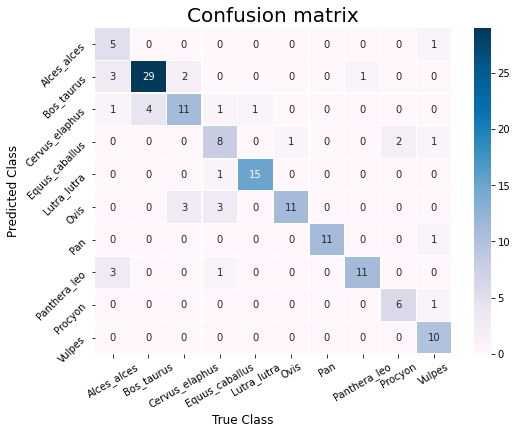

In [186]:
c_matrix(y_pred, test_generator.classes, species)

In [187]:
def accuracy_loss(history):
    plt.figure(figsize=(20,10))
    #
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label = "train_accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="train_accuracy", color ="blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15)
    #
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Test loss", color = "blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15)

In [189]:
#monodim_model = net1.to_json()
#
#with open("monodim_model.json", "w") as json_file:
#    json_file.write(monodim_model)
    
load_status = model.load_weights("monodim_weights")
load_status.assert_consumed()

In [190]:
performance1 = model.evaluate(test_generator)

5/5 [==============================] - 1s 152ms/step - loss: 0.7120 - accuracy: 0.7905


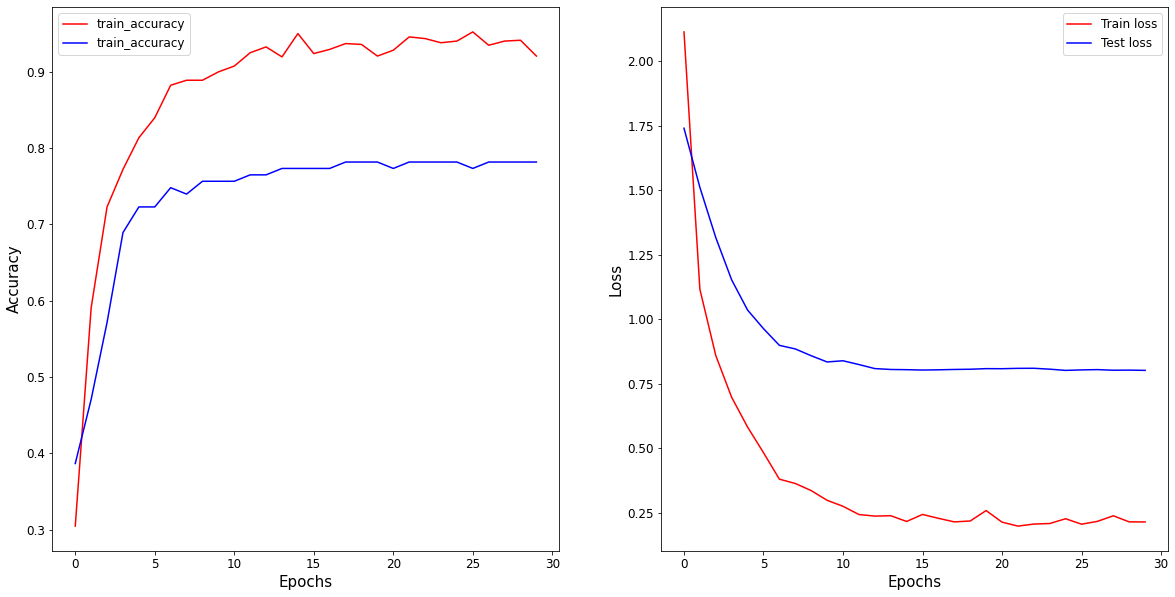

In [188]:
accuracy_loss(history1)